# R-Learner

The R-Learner is a metalearner inspired by [Robinson (1988)](https://www.jstor.org/stable/1912705). Estimation occurs in two steps:

1. Estimate two models: (i) an "outcome" model, $E(Y\mid X)$, and (ii) a "propensity score" model, $E(T\mid X)$. Use these models to residualize outcome $Y$ and treatment $T$ to obtain $\tilde{Y}$ and $\tilde{T}$, respectively. As in [DML](https://arxiv.org/pdf/1608.00060.pdf), residualization should be done using cross-fitted model predictions.
2. Estimate the auxiliary regression, $\tilde{Y} \sim \tilde{Z}$, to obtain the CATE function, where $\tilde{Z} = \tilde{T} \tau(X)$.

For a detailed overview of the R-Learner, see [Nie and Wager (2020)](https://arxiv.org/pdf/1712.04912.pdf).

## Other Useful Resources

Please refer to [causalml](https://github.com/uber/causalml/blob/master/README.md) and [EconML](https://github.com/py-why/EconML/blob/main/README.md) GitHub repositories for more useful resources.

## Example

In this notebook, we assess the performance of these CATE estimators on synthetic data.

**Notebook contents:**

1. Example usage with synthetic data

2. Example usage with semi-synthetic data

*Note: this notebook borrows heavily from the [EconML GitHub repository](https://github.com/py-why/EconML/tree/main) on Github. See [notebook](https://github.com/py-why/EconML/blob/main/notebooks/Metalearners%20Examples.ipynb).*

In [1]:
# base packages
import os
import sys
sys.path.append(os.path.abspath('..'))

# import packages
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor

# user-defined packages
from helper.data_utilities import generate_data_example1, generate_data_example2
from metalearners.rlearner import RLearner
from metalearners.slearner import SLearner
from metalearners.tlearner import TLearner

%matplotlib inline

## 1. Example Usage with Synthetic Data

### 1.1. DGP

We use the data generating process (DGP) from [Kunzel et al.](https://arxiv.org/abs/1706.03461). The DGP is described by the following equations:

$
Y = \mu_1(x) \cdot T + \mu_0(x) \cdot (1-T) + \epsilon \\
T \sim Bern(e(x)), \; e(x) = P(T=1|X=x)
$

where 

$
\mu_0(x) = x^T\beta,\; with \;\beta\sim Unif([-3, 3]^d),\; X_i \sim N(0, \Sigma)\\
\mu_1(x) = \mu_0(x) + 8 \mathbb{I}(x_2>0.1) => CATE(x) = 8 \mathbb{I}(x_2>0.1)
$

In [2]:
# DGP constants
d = 5         # dim(X_i)
n = 1000      # num train obs
n_test = 250  # num test obs

Y, T, X, X_test, treatment_effect = generate_data_example1(d, n, n_test, seed=123)

### 1.2. Train Estimators

In [3]:
PARAM_GRID = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2],
    'min_child_weight': [1.e-1],
    'lambda': [10.],
}

#### 1.2.1. R-Learner

In [4]:
# instantiate initial model architectures
outcome_model = XGBRegressor(objective='reg:squarederror')
propensity_model = XGBRegressor(objective='reg:logistic')
tau_model = XGBRegressor(objective='reg:squarederror')

# instantiate R-Learner
R_learner = RLearner(outcome_model, propensity_model, tau_model)

# tune models
R_learner.tune(X, Y, T,
               param_grid_outcome_model=PARAM_GRID,
               param_grid_propensity_model=PARAM_GRID,
               param_grid_tau_model=PARAM_GRID)

# fit
R_learner.fit(X, Y, T)

# predict on test data
R_te = R_learner.predict(X_test)

Tuning outcome_model...
Best hyperparameters for outcome_model:
{'lambda': 10.0, 'max_depth': 2, 'min_child_weight': 0.1, 'n_estimators': 100} 

Tuning propensity_model...
Best hyperparameters for propensity_model:
{'lambda': 10.0, 'max_depth': 2, 'min_child_weight': 0.1, 'n_estimators': 50} 

Tuning tau_model...
Best hyperparameters for tau_model:
{'lambda': 10.0, 'max_depth': 2, 'min_child_weight': 0.1, 'n_estimators': 200} 



#### 1.2.2. S-Learner

In [5]:
# instantiate initial model architecture
params = {
    'max_depth': 6,
    'n_estimators': 100,
    'min_child_weight': 1e-2,
    'objective': 'reg:squarederror'
}
overall_model = XGBRegressor(**params)
S_learner = SLearner(overall_model=overall_model)

# fit
S_learner.fit(X, Y, T)

# predict on test data
S_te = S_learner.predict(X_test)

#### 1.2.3. T-Learner

In [6]:
# instantiate initial model architecture
params = {
    'max_depth': 6,
    'n_estimators': 100,
    'min_child_weight': 1e-2,
    'objective': 'reg:squarederror'
}
mu1_model = XGBRegressor(**params)
mu0_model = XGBRegressor(**params)
T_learner = TLearner(mu1_model=mu1_model, mu0_model=mu0_model)

# fit
T_learner.fit(X, Y, T)

# predict on test data
T_te = T_learner.predict(X_test)

### 1.3. Visual Comparisons

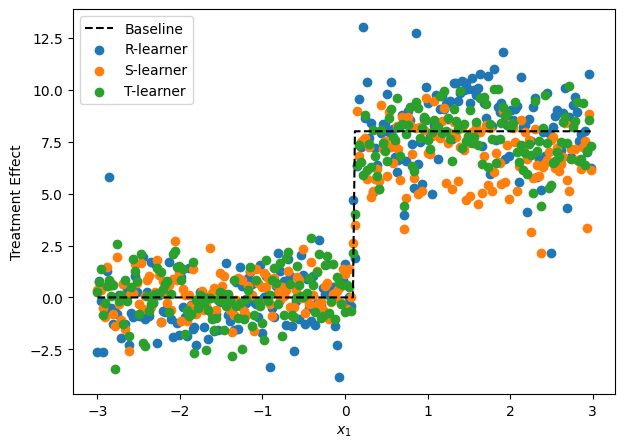

In [7]:
### Comparison plot of the different learners
plt.figure(figsize=(7, 5))
plt.plot(X_test[:, 1], np.apply_along_axis(treatment_effect, 1, X_test), color='black', ls='--', label='Baseline')
plt.scatter(X_test[:, 1], R_te, label="R-learner")
plt.scatter(X_test[:, 1], S_te, label="S-learner")
plt.scatter(X_test[:, 1], T_te, label="T-learner")
plt.xlabel('$x_1$')
plt.ylabel('Treatment Effect')
plt.legend()
plt.show()

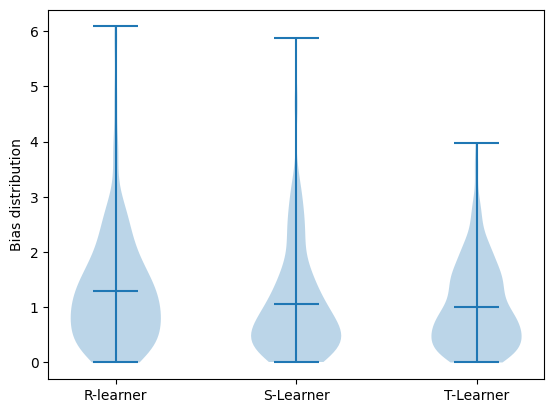

In [8]:
# Visualization of bias distribution
expected_te = np.apply_along_axis(treatment_effect, 1, X_test)
plt.violinplot(
    [
        np.abs(R_te - expected_te),
        np.abs(S_te - expected_te),
        np.abs(T_te - expected_te)
    ], showmeans=True)
plt.ylabel("Bias distribution")
plt.xticks([1, 2, 3], ['R-learner', 'S-Learner', 'T-Learner'])
plt.show()

In [9]:
# RMSE
print('------')
print(' RMSE ')
print('------')
print('R-Learner: ', np.round(np.sqrt(np.mean((R_te - expected_te) ** 2)), 3))
print('S-Learner: ', np.round(np.sqrt(np.mean((S_te - expected_te) ** 2)), 3))
print('T-Learner: ', np.round(np.sqrt(np.mean((T_te - expected_te) ** 2)), 3))

------
 RMSE 
------
R-Learner:  1.676
S-Learner:  1.452
T-Learner:  1.275


## 2. Example Usage with Semi-synthetic Data

### 2.1. DGP

We use the Response Surface B from [Hill (2011)](https://www.tandfonline.com/doi/pdf/10.1198/jcgs.2010.08162) to generate sythetic outcome surfaces from real-world covariates and treatment assignments (Infant Health Development Program data). Since the original data was part of a randomized trial, a subset of the treated infants (those with non-white mothers) has been removed from the data in order to mimic the observational data setting. For more details, see [Hill (2011)](https://www.tandfonline.com/doi/pdf/10.1198/jcgs.2010.08162).


The DGP is described by the following equations:

$
Y(0) = e^{(X+W)\beta} + \epsilon_0, \;\epsilon_0 \sim N(0, 1)\\
Y(1) = X\beta - \omega + \epsilon_1, \;\epsilon_1 \sim N(0, 1)\\
$

where $X$ is a covariate matrix, $W$ is a constant matrix with entries equal to $0.5$ and $w$ is a constant calculated such that the CATT equals $4$.

In [10]:
Y, T, X, expected_te = generate_data_example2(seed=123)

### 2.2. Train Estimators

In [11]:
# R-learner
R_learner.fit(X, Y, T)
R_te = R_learner.predict(X)

In [12]:
# S-learner
S_learner.fit(X, Y, T)
S_te = S_learner.predict(X)

In [13]:
# T-learner
T_learner.fit(X, Y, T)
T_te = T_learner.predict(X)

### 2.3. Visual Comparisons

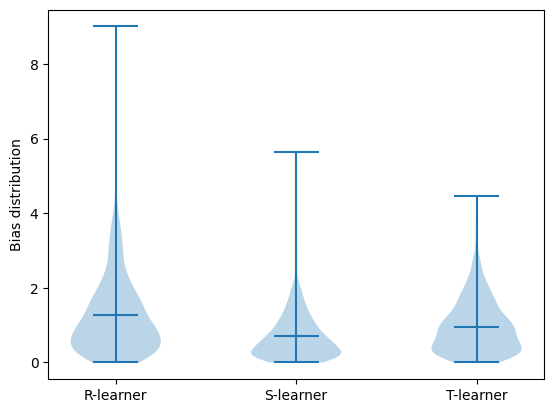

In [14]:
# Visualization of bias distribution
plt.violinplot(
    [
        np.abs(R_te - expected_te),
        np.abs(S_te - expected_te),
        np.abs(T_te - expected_te)
    ], showmeans=True)
plt.ylabel("Bias distribution")
plt.xticks([1, 2, 3], ['R-learner', 'S-learner', 'T-learner'])
plt.show()

In [15]:
print('------')
print(' RMSE ')
print('------')
print('R-Learner: ', np.round(np.sqrt(np.mean((R_te - expected_te) ** 2)), 3))
print('S-Learner: ', np.round(np.sqrt(np.mean((S_te - expected_te) ** 2)), 3))
print('T-Learner: ', np.round(np.sqrt(np.mean((T_te - expected_te) ** 2)), 3))

------
 RMSE 
------
R-Learner:  1.658
S-Learner:  0.97
T-Learner:  1.201
